PENDING: WHAT IS WRONG

In the function rolling_forecast, every forecast of the test set uses all days until the previous day (t-1), like every day you do the forecast of tomorrow. That way it build a set of forecasts of differences.

When inverting the transformation, it uses cumsum and adds all forecasts to day 450. Being aligned with the above, it should add any difference to its corresponding real (t-1).

My preference, cumsum stays, function rolling_forecast changes. Here, we want to modify cum_sum only

In [1]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Pg 65
# SALES OF WIDGETS OVER 500 DAYS STARTING 2019
df = pd.read_csv('../data/widget_sales.csv')

df.head()

,widget_sales
0,50.496714
1,50.805493
2,51.477758
3,53.542228
4,54.873108


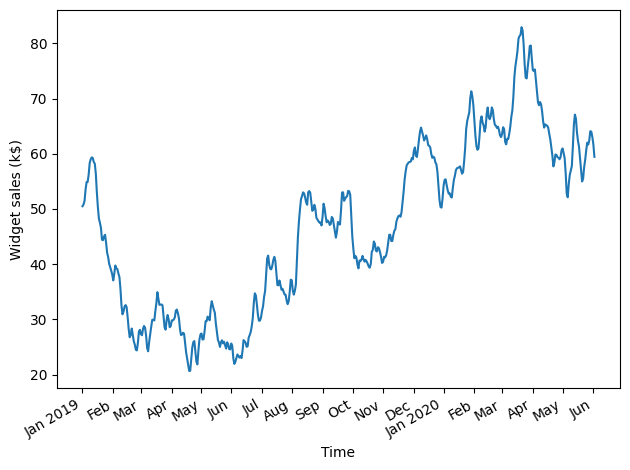

In [3]:
# Figure 4.4 in pg 66

fig, ax = plt.subplots()

ax.plot(df['widget_sales'])
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (k$)')

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498], 
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH04_F01_peixeiro.png', dpi=300)

In [4]:
# Pg 67

ADF_result = adfuller(df['widget_sales'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

# Results show non-stationarity

ADF Statistic: -1.5121662069359074
p-value: 0.5274845352272591


In [5]:
# Pg 67
widget_sales_diff = np.diff(df['widget_sales'], n=1)

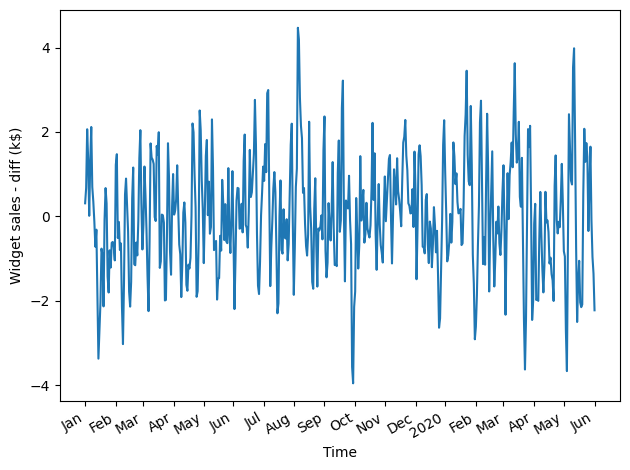

In [6]:
# Figure 4.5 in pg 68

fig, ax = plt.subplots()

ax.plot(widget_sales_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales - diff (k$)')

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498], 
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH04_F05_peixeiro.png', dpi=300)

In [7]:
# Pg 68

ADF_result = adfuller(widget_sales_diff)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

# Results show stationarity

ADF Statistic: -10.57665778034196
p-value: 7.076922818587193e-19


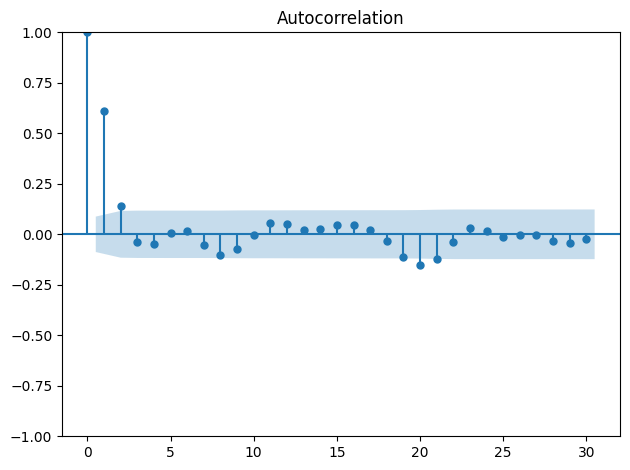

In [8]:
# Pg 68
# Figure 4.6 in pg 69

plot_acf(widget_sales_diff, lags=30)

plt.tight_layout()

plt.savefig('figures/CH04_F06_peixeiro.png', dpi=300)

Coefficients significant until lag 2   ->   stationary moving average process of order 2

#### 4.2 Forecasting a Moving Average process

In [9]:
# Pg 69

df_diff = pd.DataFrame({'widget_sales_diff': widget_sales_diff})

train = df_diff[:int(0.9*len(df_diff))]
test = df_diff[int(0.9*len(df_diff)):]

print(len(train))
print(len(test))

449
50


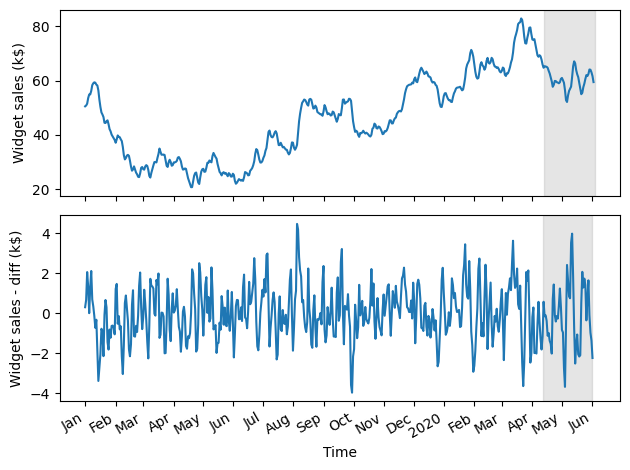

In [10]:
# Pg 70
# Figure 4.7 in pg 70

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

ax1.plot(df['widget_sales'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Widget sales (k$)')
ax1.axvspan(450, 500, color='#808080', alpha=0.2)

ax2.plot(df_diff['widget_sales_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Widget sales - diff (k$)')
ax2.axvspan(449, 498, color='#808080', alpha=0.2)

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498], 
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH04_F07_peixeiro.png', dpi=300)

In [ ]:
# Pg 72-73

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'MA':
        pred_MA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(i, i + window - 1) # changed from (0, i + window - 1) to (i, i + window - 1), no need to calculate them all
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
            
        return pred_MA

In [12]:
# Pg 73

pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1 #2

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'MA')

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_MA'] = pred_MA

pred_df.head()

,widget_sales_diff,pred_mean,pred_last_value,pred_MA
449,-1.170131,0.034319,-1.803658,-1.078833
450,0.580967,0.031643,-1.170131,-0.352047
451,-0.144902,0.032861,0.580967,0.781223
452,-0.096564,0.032468,-0.144902,-0.562355
453,-0.372334,0.032183,-0.096564,0.168994


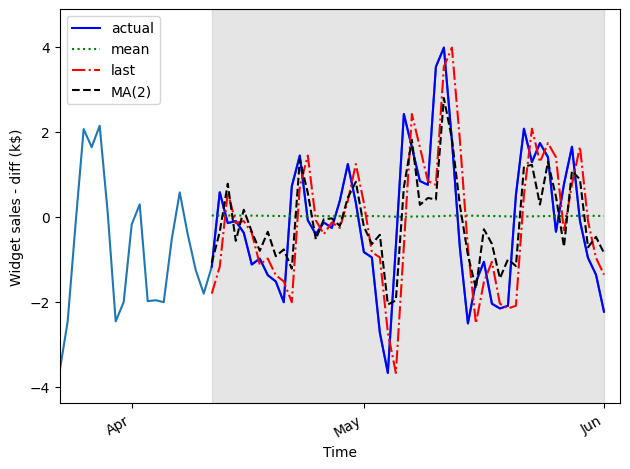

In [13]:
# Figure 4.8 in pg 74

fig, ax = plt.subplots()

ax.plot(df_diff['widget_sales_diff'])
ax.plot(pred_df['widget_sales_diff'], 'b-', label='actual')
ax.plot(pred_df['pred_mean'], 'g:', label='mean')
ax.plot(pred_df['pred_last_value'], 'r-.', label='last')
ax.plot(pred_df['pred_MA'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Widget sales - diff (k$)')

ax.axvspan(449, 498, color='#808080', alpha=0.2)

ax.set_xlim(430, 500)

plt.xticks(
    [439, 468, 498], 
    ['Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH04_F08_peixeiro.png', dpi=300)

In [14]:
# Pg 74

from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_last_value'])
mse_MA = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_MA'])

print(mse_mean, mse_last, mse_MA)

2.5567834134970195 1.7420118011899797 1.1261667874839527


MSE[mse_mean, mse_last, mse_MA]   
Window = 2  
2.5606299456880537 3.2494260812249225 1.9481714498035272  
Window = 1  
2.5567834134970195 1.7420118011899797 1.1261667874839527  

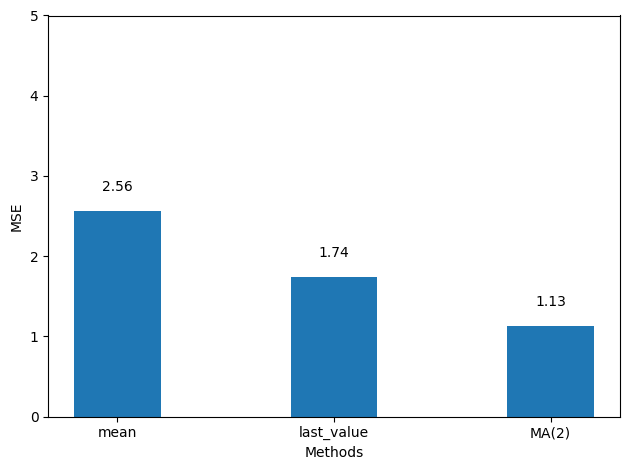

In [15]:
# Figure 4.9 in pg 75

fig, ax = plt.subplots()

x = ['mean', 'last_value', 'MA(2)']
y = [mse_mean, mse_last, mse_MA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 5)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()

plt.savefig('figures/CH04_F09_peixeiro.png', dpi=300)

*****************************************************************

Inverting transformation (differencing)

Instead of:

In [ ]:
# # Pg 76, proofed in pg 75

# df['pred_widget_sales'] = pd.Series()
# df['pred_widget_sales'][450:] = df['widget_sales'].iloc[450] + pred_df['pred_MA'].cumsum()

Let's do:

In [26]:
df['widget_sales'][449:].head()  # shape (500,)

449    65.906136
450    64.736005
451    65.316972
452    65.172070
453    65.075506
Name: widget_sales, dtype: float64

In [16]:
pred_df['pred_MA'].head()  # shape (50,)

449   -1.078833
450   -0.352047
451    0.781223
452   -0.562355
453    0.168994
Name: pred_MA, dtype: float64

In [27]:
zz=df['widget_sales'][449:]+pred_df['pred_MA']
zz.head()

449    64.827303
450    64.383958
451    66.098195
452    64.609716
453    65.244500
dtype: float64

In [35]:
zzz=zz.shift(periods=1).dropna()
zzz.head()

450    64.827303
451    64.383958
452    66.098195
453    64.609716
454    65.244500
dtype: float64

In [36]:
zzz.tail()

495    63.517841
496    64.970561
497    63.276644
498    62.560096
499    60.822837
dtype: float64

In [37]:
df['pred_widget_sales'] = pd.Series()
df['pred_widget_sales'][450:] = zzz

*****************************************************************

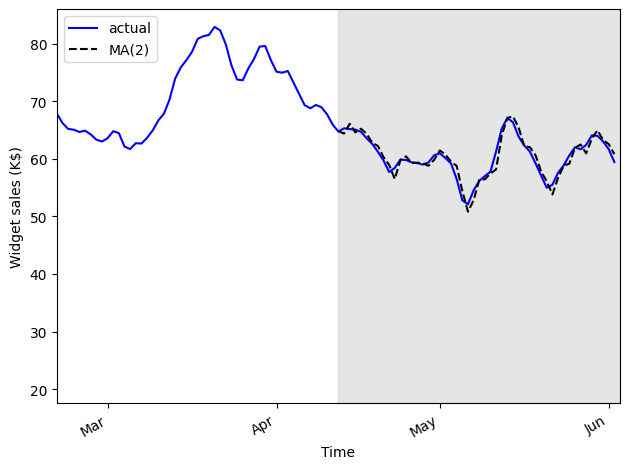

In [38]:
# Figure 4.11 in pg 77

fig, ax = plt.subplots()

ax.plot(df['widget_sales'], 'b-', label='actual')
ax.plot(df['pred_widget_sales'], 'k--', label='MA(2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (K$)')

ax.axvspan(450, 500, color='#808080', alpha=0.2)

ax.set_xlim(400, 500)

plt.xticks(
    [409, 439, 468, 498], 
    ['Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH04_F11_peixeiro.png', dpi=300)

# Inverse-transformed MA(2) forecasts

In [39]:
# Pg 77

from sklearn.metrics import mean_absolute_error

mae_MA_undiff = mean_absolute_error(df['widget_sales'].iloc[450:], df['pred_widget_sales'].iloc[450:])

print(mae_MA_undiff)

0.8450525478654337


Therefore, our predictions are, on averrage, off by:  
WINDOW=1  
$845

Now this result is exactly the same as the one obtained with ARIMA(0,1,2) in file CH07_exercise_7.5.1_4_0.1.2_BOOK.ipynb